<a href="https://colab.research.google.com/github/satya2909/Multimodal_biometric_system/blob/main/fingerprint_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: give code to unzip the file given and store

import zipfile
import os

# Define the path to the zip file
zip_file_path = '/content/separated_fingerprints.zip'

# Define the directory where you want to extract the contents
extract_dir = '/content/separated_fingerprints'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Check if the zip file exists before attempting to open it
if os.path.exists(zip_file_path):
  # Open the zip file in read mode
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extract_dir)
  print(f"Successfully unzipped '{zip_file_path}' to '{extract_dir}'")
else:
  print(f"Error: The file '{zip_file_path}' does not exist.")

# Optionally, list the extracted files to verify
if os.path.exists(extract_dir):
  print("Extracted files:")
  !ls {extract_dir}


BadZipFile: File is not a zip file

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import os
import re
from collections import defaultdict

# New data root
data_root = "/content/separated_fingerprints"

# Step 1: Walk through each user folder
train_paths = []
test_paths = []
user_folders = sorted(os.listdir(data_root))
user_id_to_index = {}

for idx, folder in enumerate(user_folders):
    user_path = os.path.join(data_root, folder)
    if not os.path.isdir(user_path):
        continue

    # Label assignment
    user_id_to_index[folder] = idx

    # File paths
    for fname in os.listdir(user_path):
        full_path = os.path.join(user_path, fname)
        if fname == "fingerprint.png":
            test_paths.append(full_path)
        elif fname.startswith("fingerprint_aug") and fname.endswith(".png"):
            train_paths.append(full_path)

# Step 2: Define dataset class
class FingerprintDataset(Dataset):
    def __init__(self, image_paths, user_id_to_index, transform=None):
        self.image_paths = image_paths
        self.user_id_to_index = user_id_to_index
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        # Extract user ID from folder name
        user_id = os.path.basename(os.path.dirname(image_path))
        label = self.user_id_to_index[user_id]

        return image, label

# Step 3: Create datasets and dataloaders
train_dataset = FingerprintDataset(train_paths, user_id_to_index)
test_dataset = FingerprintDataset(test_paths, user_id_to_index)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os
import re

# Path to fingerprint dataset root
raw_image_dir = "/content/separated_fingerprints"

# Collect all train/test images
user_to_train_images = defaultdict(list)
user_to_test_image = {}

# Walk through each user folder
for user_folder in sorted(os.listdir(raw_image_dir)):
    user_path = os.path.join(raw_image_dir, user_folder)
    if not os.path.isdir(user_path):
        continue

    all_files = os.listdir(user_path)
    train_imgs = [os.path.join(user_path, f) for f in all_files if f.startswith("fingerprint_aug") and f.endswith(".png")]
    test_img = os.path.join(user_path, "fingerprint.png") if "fingerprint.png" in all_files else None

    # Only keep users who have at least one augmented image and one original
    if train_imgs and test_img:
        user_to_train_images[user_folder].extend(train_imgs)
        user_to_test_image[user_folder] = test_img

# Final list of valid users
valid_users = list(user_to_train_images.keys())
print(f"Total valid users: {len(valid_users)}")

# Sanity check
if len(valid_users) == 0:
    raise ValueError("No users left after filtering.")

# Split users into train/test (no image leakage)
train_users, test_users = train_test_split(valid_users, test_size=0.2, random_state=42)

# Collect train/test image paths
train_paths = [img for uid in train_users for img in user_to_train_images[uid]]
test_paths = [user_to_test_image[uid] for uid in test_users]

# Safety check: No overlap in users
assert not set(train_users) & set(test_users), "User leakage detected!"

# Debug info
print(f"Train images: {len(train_paths)}")
print(f"Test images: {len(test_paths)}")


Total valid users: 100
Train images: 800
Test images: 20


In [ ]:
from transformers import ViTModel, ViTConfig
import torch.nn as nn

class FingerprintViT(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(FingerprintViT, self).__init__()
        config = ViTConfig()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224") if pretrained else ViTModel(config)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        cls_token = outputs.last_hidden_state[:, 0]  # [CLS] token
        return self.classifier(cls_token)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(user_id_to_index)

model = FingerprintViT(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {avg_loss:.4f} | Train Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    print(f"Val Loss: {avg_loss:.4f} | Val Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 12
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [],[]

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_fingerprint_vit.pth")
        print("✅ Saved best model!")



Epoch 1/12


Training: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]


Train Loss: 4.3174 | Train Accuracy: 13.90%


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.63it/s]


Val Loss: 3.3491 | Val Accuracy: 61.00%
✅ Saved best model!

Epoch 2/12


Training: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]


Train Loss: 2.8193 | Train Accuracy: 74.70%


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]


Val Loss: 1.7998 | Val Accuracy: 98.00%
✅ Saved best model!

Epoch 3/12


Training: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]


Train Loss: 1.4385 | Train Accuracy: 98.50%


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]


Val Loss: 0.7488 | Val Accuracy: 100.00%
✅ Saved best model!

Epoch 4/12


Training: 100%|██████████| 63/63 [00:35<00:00,  1.80it/s]


Train Loss: 0.6246 | Train Accuracy: 100.00%


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]


Val Loss: 0.3287 | Val Accuracy: 100.00%

Epoch 5/12


Training: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]


Train Loss: 0.2966 | Train Accuracy: 100.00%


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.40it/s]


Val Loss: 0.1740 | Val Accuracy: 100.00%

Epoch 6/12


Training: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]


Train Loss: 0.1675 | Train Accuracy: 100.00%


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.41it/s]


Val Loss: 0.1093 | Val Accuracy: 100.00%

Epoch 7/12


Training: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]


Train Loss: 0.1098 | Train Accuracy: 100.00%


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.40it/s]


Val Loss: 0.0812 | Val Accuracy: 100.00%

Epoch 8/12


Training: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]


Train Loss: 0.0804 | Train Accuracy: 100.00%


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.24it/s]


Val Loss: 0.0625 | Val Accuracy: 100.00%

Epoch 9/12


Training: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]


Train Loss: 0.0623 | Train Accuracy: 100.00%


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.24it/s]


Val Loss: 0.0498 | Val Accuracy: 100.00%

Epoch 10/12


Training: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]


Train Loss: 0.0501 | Train Accuracy: 100.00%


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Val Loss: 0.0418 | Val Accuracy: 100.00%

Epoch 11/12


Training: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]


Train Loss: 0.0415 | Train Accuracy: 100.00%


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Val Loss: 0.0361 | Val Accuracy: 100.00%

Epoch 12/12


Training: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]


Train Loss: 0.0351 | Train Accuracy: 100.00%


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.24it/s]

Val Loss: 0.0309 | Val Accuracy: 100.00%


In [ ]:
# After training loop
print("\nTesting best model on test set:")
model.load_state_dict(torch.load("/content/best_fingerprint_vit.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")



Testing best model on test set:


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]

Val Loss: 0.7488 | Val Accuracy: 100.00%
Test Loss: 0.7488 | Test Accuracy: 100.00%


In [ ]:
# prompt: give me code to download best_fingerprint_vit.pth i have in files with required imports

from google.colab import files

files.download("best_fingerprint_vit.pth")
print("\nDownloaded 'best_fingerprint_vit.pth'")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Downloaded 'best_fingerprint_vit.pth'


In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Extract user IDs from your dictionary
user_ids = list(user_id_to_index.keys())

# Create and fit label encoder
fp_label_encoder = LabelEncoder()
fp_label_encoder.fit(user_ids)

# Save it
joblib.dump(fp_label_encoder, "weights/fingerprint_label_encoder.pkl")
print("✅ Saved fingerprint_label_encoder.pkl")


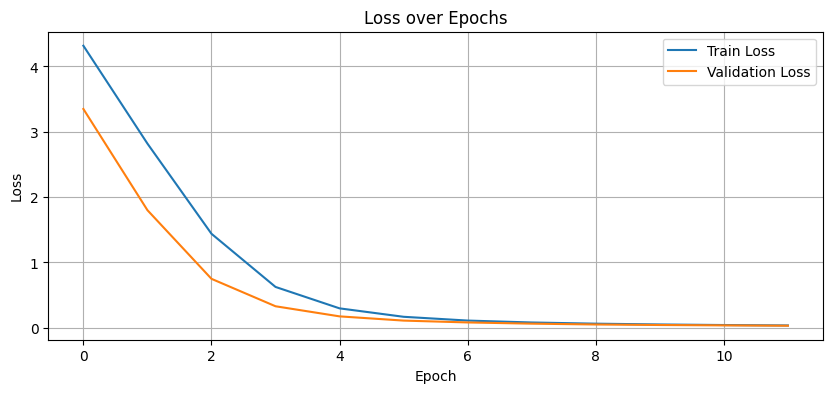

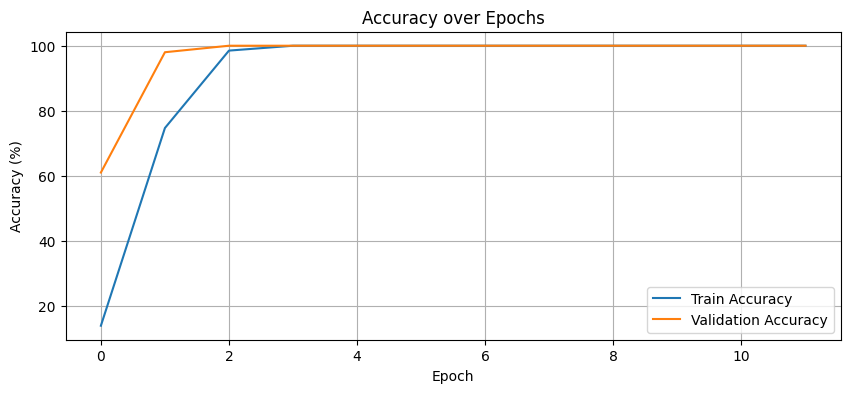

In [ ]:
import matplotlib.pyplot as plt

# Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy Curve
plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

def get_predictions_and_labels(model, loader, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            y_scores.append(probs)
            y_true.append(labels.cpu().numpy())

    return np.concatenate(y_scores), np.concatenate(y_true)


In [ ]:
def plot_roc(y_scores, y_true, num_classes):
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [ ]:
def plot_far_frr(y_true, y_pred_probs, num_classes):
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    thresholds = np.linspace(0, 1, 100)
    avg_far = []
    avg_frr = []

    for thresh in thresholds:
        far, frr = [], []
        for i in range(num_classes):
            preds = (y_pred_probs[:, i] >= thresh).astype(int)
            actuals = y_true_bin[:, i]

            TP = np.sum((preds == 1) & (actuals == 1))
            TN = np.sum((preds == 0) & (actuals == 0))
            FP = np.sum((preds == 1) & (actuals == 0))
            FN = np.sum((preds == 0) & (actuals == 1))

            far.append(FP / (FP + TN + 1e-6))
            frr.append(FN / (FN + TP + 1e-6))

        avg_far.append(np.mean(far))
        avg_frr.append(np.mean(frr))

    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, avg_far, label="FAR", color='r')
    plt.plot(thresholds, avg_frr, label="FRR", color='b')
    plt.xlabel("Threshold")
    plt.ylabel("Rate")
    plt.title("FAR vs FRR")
    plt.legend()
    plt.grid(True)
    plt.show()


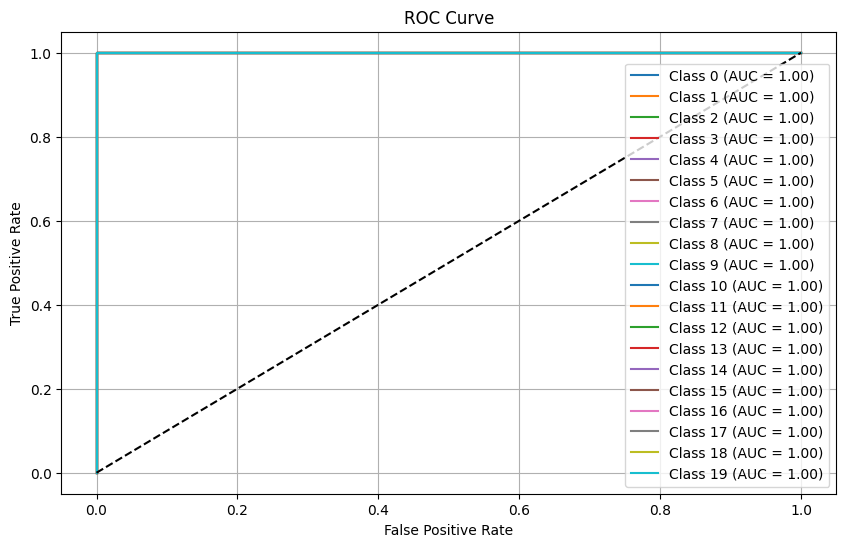

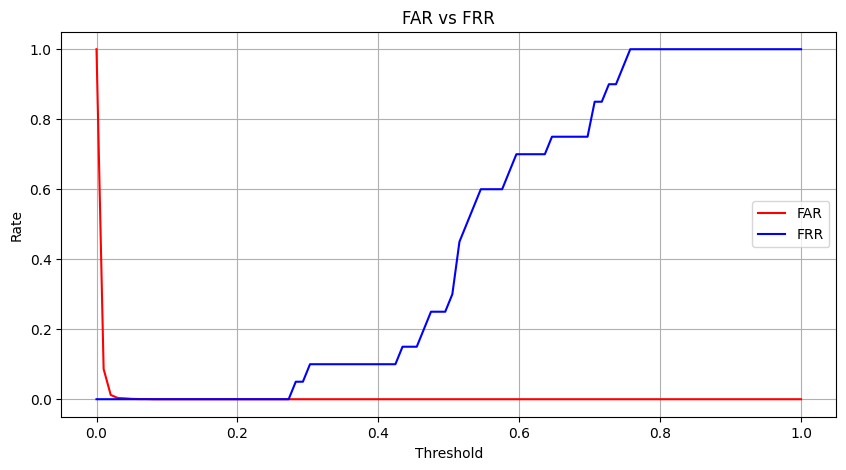

In [ ]:
# Get predictions
y_scores, y_true = get_predictions_and_labels(model, test_loader, device)

# Plot ROC
plot_roc(y_scores, y_true, num_classes=20)

# Plot FAR vs FRR
plot_far_frr(y_true, y_scores, num_classes=20)
